# dependencies

In [ ]:
!pip install -U "tensorflow-text==2.15.*"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 87.1 MB/s eta 0:00:00


In [ ]:
!pip install "tf-models-official==2.15.*  "

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=6a4491a967995119b105f4d5b179347586ebb528513d13a70d8cf4c9eceed53b
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
# prompt: read from the drive processed_data_with_outliers.csv under pfe/pfe-dataset_95

import pandas as pd

df = pd.read_csv('/content/drive/My Drive/master_files/data_preprocessed.csv')

df.shape

(24960, 5)

In [ ]:
df.head()

,Unnamed: 0,_id,text,label,label_int
0,0,f7700f82-5425-4dcc-965f-13b20b13b19d,"We present two experiments, one small prelimin...",m,2
1,1,393fb8b1-5b1b-4ef0-8499-fd8303f84624,The two adversarial cases considered in this w...,m,2
2,2,a9aa6217-a201-4463-a5e6-08fe23bfc901,With modern technology having reached a stage ...,i,1
3,3,276590e3-98b1-4b78-b3b9-d3a3dd75c6cc,Systems are generally considered as complex if...,r,3
4,4,798d3d4c-278f-4749-a8b7-e2dbfd64e6e9,Near-infrared detection experimentation will h...,w,4


In [ ]:
df['text'] = df['text'].apply(lambda x: x.lower())

In [ ]:
df['label'].value_counts()

label
m    4992
i    4992
r    4992
w    4992
d    4992
Name: count, dtype: int64

# bert initialization

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = [df.iloc[0]['text']]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2057 2556 2048 7885 1010 2028 2235 8824 7551 4738 2006]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.7401056  -0.4920876  -0.9549995   0.5043797   0.7925115  -0.16304171
 -0.07447566  0.29365456 -0.8369011  -0.999929   -0.60932684  0.9078106 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.5717009  -0.8465779  -0.08719304 ...  0.17067595  0.39618886
   0.6599952 ]
 [ 0.7547348   0.21854338 -0.7170127  ...  0.59317493  1.3912194
  -0.7275242 ]
 [-0.44553417  1.216872    0.3360427  ...  0.3684116   0.08467222
  -0.78218323]
 ...
 [-0.11375228 -0.48948297 -0.61441815 ... -0.52854484  0.48529005
   0.3058846 ]
 [ 0.9840286  -0.33879516 -0.0715544  ...  0.00917066 -0.04463868
  -0.04734806]
 [-0.70381075  0.3922867   0.03688725 ... -0.07914232  0.38746694
   1.0614694 ]]


In [ ]:
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
class_names = np.unique(df['label_int'].to_numpy())

def create_tf_dataset_from_dataframe(data, batch_size=32, shuffle=True, seed=42):
  text = data['text'].to_numpy()
  labels = data['label_int'].to_numpy()
   # Get unique class labels

  # One-hot encode labels
  labels = to_categorical(labels, num_classes=len(class_names))

  dataset = tf.data.Dataset.from_tensor_slices(((text), labels))
  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(data), seed=seed)
  dataset = dataset.batch(batch_size)
  # You can add further preprocessing steps here as needed
  return dataset

# Define training, validation, and test sets based on your split logic
# (replace this with your actual splitting logic)

train_df = df.sample(frac=0.8, random_state=seed)
val_df = df.drop(train_df.index).sample(frac=0.5, random_state=seed)
test_df = df.drop(train_df.index).drop(val_df.index)


# Create TensorFlow datasets for each split
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32  # Adjust batch size as needed
seed = 42

train_ds = create_tf_dataset_from_dataframe(train_df, batch_size=batch_size, shuffle=True, seed=seed)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = create_tf_dataset_from_dataframe(val_df, batch_size=batch_size, shuffle=False, seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = create_tf_dataset_from_dataframe(test_df, batch_size=batch_size, shuffle=False, seed=seed)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [ ]:
df.shape,test_df.shape,val_df.shape,train_df.shape

((24960, 5), (2496, 5), (2496, 5), (19968, 5))

In [ ]:
import keras


def build_classifier_model( dropout_rate=0.1):
    # Text input
    text_input = keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    bert_output = outputs['pooled_output']

    # Add dropout layer
    net = keras.layers.Dropout(dropout_rate)(bert_output)

    # Output layer
    net = keras.layers.Dense(  len(class_names), activation='softmax', name='classifier')(net)

    return keras.Model(inputs=text_input, outputs=net)



In [ ]:
model = build_classifier_model()
bert_raw_result = model(tf.constant(['testu']))
print(bert_raw_result)

tf.Tensor([[0.04497102 0.15789264 0.24658935 0.19556548 0.35498157]], shape=(1, 5), dtype=float32)


In [ ]:
print(class_names)
t = to_categorical(class_names, num_classes=len(class_names))
t

[0 1 2 3 4]


array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

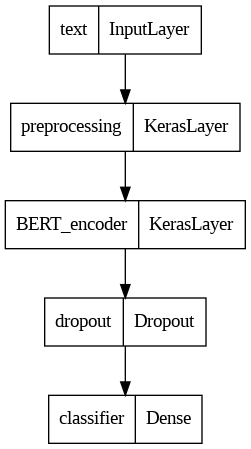

In [ ]:
keras.utils.plot_model(model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [ ]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define a callback to save model checkpoints
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5',
                                      save_best_only=True,  # Save only the best model
                                      monitor='val_loss',   # Monitor validation loss
                                      mode='min')           # Minim
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


In [ ]:
print(class_names)
print(len(class_names))
df.shape


[0 1 2 3 4]
5


(24960, 5)

In [ ]:
  loss = keras.losses.CategoricalCrossentropy()
  METRICS= [
      keras.metrics.F1Score(name='f1_average'),


  ]

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS

                         )

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,callbacks=[checkpoint_callback,early_stopping_callback],
                               workers=8,
                               use_multiprocessing=True

                               )

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/2
624/624 [==============================] - ETA: 0s - loss: 0.9444 - f1_average: 0.6283

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


624/624 [==============================] - 339s 515ms/step - loss: 0.9444 - f1_average: 0.6283 - val_loss: 0.7378 - val_f1_average: 0.7229
Epoch 2/2
624/624 [==============================] - 321s 515ms/step - loss: 0.6209 - f1_average: 0.7706 - val_loss: 0.7226 - val_f1_average: 0.7445


In [ ]:
loss, accuracy = model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

78/78 [==============================] - 13s 166ms/step - loss: 0.7505 - f1_average: 0.7309
Loss: 0.7505072355270386
Accuracy: [0.7726788  0.70238096 0.67992425 0.69990027 0.7995951 ]


dict_keys(['loss', 'f1_average', 'val_loss', 'val_f1_average'])


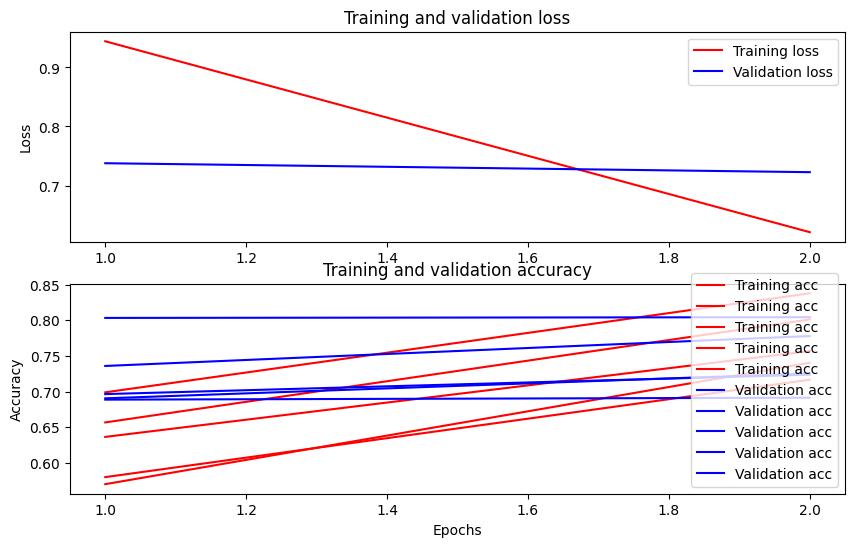

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['f1_average']
val_acc = history_dict['val_f1_average']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'imrad-moves-dataset'
saved_model_path = '/content/drive/MyDrive/master_files/v1_no_augmentation/model_epoch_2/{}_bert'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = keras.models.load_model(saved_model_path)

In [ ]:
epochs

range(1, 3)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history1 = model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=2+1,callbacks=[checkpoint_callback,early_stopping_callback],
                               workers=8,
                               use_multiprocessing=True,
                               initial_epoch=2

                               )

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 3/3
624/624 [==============================] - 319s 512ms/step - loss: 0.5225 - f1_average: 0.8107 - val_loss: 0.7226 - val_f1_average: 0.7445


In [ ]:

print(f'Training model with {tfhub_handle_encoder}')
history1 = model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=4,callbacks=[checkpoint_callback,early_stopping_callback],
                               workers=8,
                               use_multiprocessing=True,
                               initial_epoch=3

                               )

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 4/4
142/624 [=====>........................] - ETA: 3:57 - loss: 0.5532 - f1_average: 0.7977

KeyboardInterrupt: 